In [1]:
%load_ext autoreload
%autoreload 2

import os

import sys
sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts')

import utilities2014
reload(utilities2014)
from utilities2014 import *

import time

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram, ward

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filters.rank import gradient

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=2)
dm._load_image()

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1
# neighbors = dm.load_pipeline_result('neighbors', 'pkl')
# sp_properties = dm.load_pipeline_result('spProps', 'npy')
# segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

# Load region proposals
# expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
# expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)
# expansion_cluster_scores = np.array(expansion_cluster_scores)

# neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
# neighbor_graph = from_dict_of_lists(neighbors_dict)

# surrounds_sps = dm.load_pipeline_result('clusterSurrounds', 'pkl')
# frontiers_sps = dm.load_pipeline_result('clusterFrontiers', 'pkl')

# texture_map = texton_hists[segmentation]
# texture_map[~dm.mask] = np.nan * np.ones((n_texton,))
# dm.save_pipeline_result(texture_map, 'textureMap', 'npy')

texture_map = dm.load_pipeline_result('textureMap', 'npy')

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [3]:
Gmax = np.load('/home/yuncong/csd395/Gmax.npy')

In [4]:
def chi2s(h1s, h2s):
    '''
    h1s is n x n_texton
    '''
    s = (h1s+h2s).astype(np.float)
    ss = (h1s-h2s)**2/s
    ss[s==0] = 0
    return np.sum(ss, axis=1)

In [15]:
segment_points = np.load('/home/yuncong/csd395/sample_landmark_0.npy')
sample_segment_int_texture = segment_points[:, 2:2+n_texton]
sample_segment_ext_texture = segment_points[:, 2+n_texton:-2]

sample_segment_vector = segment_points[:, -2:]

In [16]:
template_points_rotated_versions = []

centroid = np.mean(segment_points[:, [1,0]], axis=0)
segment_points_centered = segment_points[:, [1,0]] - centroid

thetas = np.linspace(-np.pi/4, np.pi/4, 9)

for theta in thetas:
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    sample_segment_pts = np.dot(R, segment_points_centered.T).astype(np.int).T
    shifted_sample_segment_pts = sample_segment_pts - sample_segment_pts.min(axis=0)
    
    template_points_rotated_versions.append(shifted_sample_segment_pts)
    
template_shape_rotated_versions = [pts.max(axis=0) + [1,1] for pts in template_points_rotated_versions]

In [17]:
# # visualize the templates

# for i in range(len(thetas)):

#     template_points = template_points_rotated_versions[i]
    
#     template = np.zeros(template_shape_rotated_versions[i], np.bool)
#     template[template_points[:,0], template_points[:,1]] = 1
#     plt.figure()
#     plt.title('rotated %d' % i)
#     plt.imshow(template, cmap=plt.cm.gray_r)

In [18]:
n_sample = 5
r = np.linspace(0,1,n_sample) * 20
ext_texture_sampling_positions = (sample_segment_vector[:, None, ::-1] * r[None,:,None]).astype(np.int)
int_texture_sampling_positions = (sample_segment_vector[:, None, ::-1] * -r[None,:,None]).astype(np.int)

In [19]:
def f(s, template_pts):
    vs = np.empty((len(s),), dtype=np.float)
    ss = []
    for i, (x, y) in enumerate(s):
        yy = y + template_pts[:,0]
        xx = x + template_pts[:,1]
        
        r = Gmax[yy, xx]
        
        ys = np.maximum(np.minimum(yy[:,None] + int_texture_sampling_positions[:,:,0], dm.image_height-1), 0)
        xs = np.maximum(np.minimum(xx[:,None] + int_texture_sampling_positions[:,:,1], dm.image_width-1), 0)
        avg_int_texture = np.nanmean(texture_map[ys, xs], axis=1)
        cs_int = chi2s(sample_segment_int_texture, avg_int_texture)
    
        ys = np.maximum(np.minimum(yy[:,None] + ext_texture_sampling_positions[:,:,0], dm.image_height-1), 0)
        xs = np.maximum(np.minimum(xx[:,None] + ext_texture_sampling_positions[:,:,1], dm.image_width-1), 0)
        avg_ext_texture = np.nanmean(texture_map[ys, xs], axis=1)
        cs_ext = chi2s(sample_segment_ext_texture, avg_ext_texture)
        
        v = np.nansum(r * (np.exp(-cs_int/.5) + np.exp(-cs_ext/.5)))
        ss.append(np.c_[r, cs_int, cs_ext])
        vs[i] = v
        
#         v = np.sum(r)
#         vs[i] = v
#         ss.append(None)
        
    return vs, ss

In [20]:
b = time.time()

theta = 4
grid_spacing = (10,10)

template_height, template_width = template_shape_rotated_versions[theta]
ys, xs = np.mgrid[:dm.image_height - template_height:grid_spacing[0], 
                  :dm.image_width - template_width:grid_spacing[1]]


In [21]:
# ret = []
# for s in np.array_split(zip(xs.flat, ys.flat), 16):
#     ret.append(f(s, template_points_rotated_versions[theta]))

ret = Parallel(n_jobs=16)(delayed(f)(s, template_points_rotated_versions[theta]) 
                          for s in np.array_split(zip(xs.flat, ys.flat), 8))

V, ss = zip(*ret)
vs = np.concatenate(V).copy() # without .copy() successive run of parallel will hang; don't know why..
sss = list(chain(*ss))

vss = np.reshape(vs, xs.shape)

# V = Parallel(n_jobs=16)(delayed(f)(s, template_points_rotated_versions[theta]) 
#                         for s in np.array_split(zip(xs.flat, ys.flat), 16))
# vs = np.concatenate(V)

print time.time() - b

14.5614519119


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slic

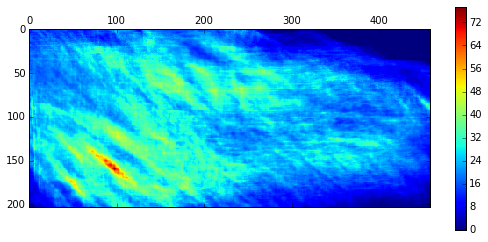

In [22]:
plt.matshow(vss);
plt.colorbar();

In [23]:
from skimage.feature import peak_local_max

peaks = peak_local_max(vss)
ypeaks = peaks[:,0]
xpeaks = peaks[:,1]

order = np.argsort(vss[ypeaks, xpeaks])[::-1]
ypeaks = ypeaks[order]
xpeaks = xpeaks[order]

In [24]:
bg_ubyte = img_as_ubyte(dm.image_rgb)

for i, (ybest, xbest) in enumerate(zip(ypeaks, xpeaks)[:3]):

    print ybest, xbest, vss[ybest, xbest]

    shifted_ys_best = ys[ybest, xbest] + template_points_rotated_versions[theta][:,0]
    shifted_xs_best = xs[ybest, xbest] + template_points_rotated_versions[theta][:,1]
    
    overlay = np.zeros_like(dm.image, np.bool)
    overlay[shifted_ys_best, shifted_xs_best] = 1
    overlay = binary_dilation(overlay, disk(5))
    bg_ubyte[overlay] = [0,255,0]

    cv2.putText(bg_ubyte, str(i), (xs[ybest, xbest], ys[ybest, xbest]), 
                cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 3, ((255,0,255)), 10)

display(bg_ubyte)

160 97 77.4924195894
174 48 55.1725598675
124 101 48.883984466


/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [ ]:
# def ransac_matching(matches):
        
#     import networkx as nx
    
#     n_boundaries1, n_boundaries2 = D_boundaries.shape
    
#     nn1 = D_boundaries.argsort(axis=1)
#     dd1 = np.sort(D_boundaries,axis=1)
#     nn1 = [nn[:np.searchsorted(d, d[0]+0.2)] for d, nn in zip(dd1, nn1)]
    
#     nn2 = D_boundaries.argsort(axis=0).T
#     dd2 = np.sort(D_boundaries,axis=0).T
#     nn2 = [nn[:np.searchsorted(d, d[0]+0.2)] for d, nn in zip(dd2, nn2)]

#     DD = np.zeros((n_boundaries1+n_boundaries2, n_boundaries1+n_boundaries2))
#     G = nx.Graph(DD)
#     G = nx.relabel_nodes(G, dict([(i,(0,i)) for i in range(n_boundaries1)]+[(n_boundaries1+j,(1,j)) for j in range(n_boundaries2)]))
#     matches = []
#     for i in range(n_boundaries1):
#         for j in range(n_boundaries2):
# #             if j in nn1[i,:k] and i in nn2[j,:k]:
#             if j in nn1[i] and i in nn2[j]:
#                 matches.append((i,j))
#                 G.add_edge((0,i), (1,j))

#     ms = [sorted(g) for g in sorted(list(nx.connected_components(G)), key=len, reverse=True) if len(g) >= 2]
        
#     groups = []
#     for mi, m in enumerate(ms):
#         d = defaultdict(list)
#         for sec_i, bnd_i in m:
#             d[sec_i].append(bnd_i)
#         A = D_boundaries[d[0]][:,d[1]]
#         rs, cs = np.unravel_index(np.argsort(D_boundaries[d[0]][:,d[1]].flat), (len(d[0]), len(d[1])))
#     #     print rs, cs
#     #     print [((sec1, d[sec1][r]), (sec2, d[sec2][c]), D_boundaries[d[sec1][r], d[sec2][c]]) for r, c in zip(rs, cs)
#     #           if D_boundaries[d[sec1][r], d[sec2][c]] < np.inf]

#         g = []
#         for r, c in zip(rs, cs):
#             if D_boundaries[d[0][r], d[1][c]] < np.inf:
#     #             print ((sec1, d[sec1][r]), (sec2, d[sec2][c]), D_boundaries[d[sec1][r], d[sec2][c]])
#                 g.append([d[0][r], d[1][c]])

#         groups.append(g)
    
# #     print groups
    
#     # RANSAC
#     import random

#     boundary1_centers = np.array([b[4][::-1] for b in boundaries1])
#     boundary2_centers = np.array([b[4][::-1] for b in boundaries2])

#     matches = []
#     scores = []

#     for ransac_iter in range(100):

#         boundary_samples = [random.sample(g, 1)[0] for g in random.sample(groups, min(len(groups), 3))]
#         X = []
#         Y = []
#         for b1, b2 in boundary_samples:
#             X.append(boundary1_centers[b1])
#             Y.append(boundary2_centers[b2])
#         X = np.array(X)
#         Y = np.array(Y)

#         T, angle = rigid_transform_from_pairs(X,Y)
#     #     print T, angle
#         if angle > np.pi/2:
#     #         print 'angle too wide'
#             matches.append([])
#             scores.append(0)
#             continue

#         boundary1_centers_trans = rigid_transform_to(boundary1_centers, T)
# #         print np.linalg.norm(boundary1_centers_trans[10]-boundary2_centers[4])

#         match = [(bi,bj) for g in groups for bi,bj in g 
#                  if np.linalg.norm(boundary1_centers_trans[bi] - boundary2_centers[bj]) < centroid_dist_limit]

#         score = len(match)

#         matches.append(match)
#         scores.append(score)

#     best = np.argmax(scores)
#     s_best = scores[best]
#     m_best = matches[best]
# #     print m_best

#     g = nx.Graph()
#     g.add_edges_from([((0, i),(1, j), {'weight': D_boundaries[D_boundaries!=np.inf].max()-D_boundaries[i,j]}) 
#                       for i,j in m_best])
#     m = nx.matching.max_weight_matching(g, maxcardinality=True)
    
#     best_match = set(((0, dict([n1,n2])[0]), (1, dict([n1,n2])[1])) for n1,n2 in m.iteritems())
    
#     print len(best_match)
    
#     return best_match